In [220]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torchvision
import torchvision.transforms as transforms
from TrafficSign import TrafficSign
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('result/trafficSigns_experiment_1')

In [221]:
transform = transforms.Compose([
    # transforms.CenterCrop(224),
    # transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.ToPILImage(),#
    transforms.Resize([32, 32]),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5])
])


batch_size = 4

# dataset = TrafficSign(annotations_file='PytorchDataset.csv',img_dir='Signs/',transform=transform)
trainset = TrafficSign(annotations_file='PytorchDataset.csv',img_dir='Signs/',transform=transform)
testset = TrafficSign(annotations_file='PytorchDataset.csv',img_dir='Signs/',transform=transform)
trainloader = DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
testloader = DataLoader(dataset=testset,batch_size=batch_size,shuffle=True)

classes = ('End', 'NoUturn', 'StopAllDay', 'NoEntry','NoLeft','NoRight','No7-7','NoStud')

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

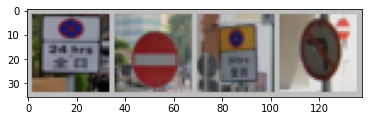

StopAllDay NoEntry StopAllDay NoLeft


In [222]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [223]:

import torch.nn as nn
import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(4,4,(220,220))
#         # self.pool = nn.MaxPool2d(6, 2)
#         self.conv2 = nn.Conv2d(4, 4, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
#
#     def forward(self, x):
#         # x = self.pool(F.relu(self.conv1(x)))
#         # x = self.pool(F.relu(self.conv2(x)))
#         # x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#
#         return x
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)
        # self.fc3 = nn.Linear(84, 5)
        #self.fc3 = nn.Linear(84, 50) 50 = num of classes
        #change here!!!!!!!!!!
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


net = Net()

In [224]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [225]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            writer.add_scalar('training loss',
                            running_loss / 20,
                            epoch * len(trainloader) + i)
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 2.100
[1,    40] loss: 2.092
[2,    20] loss: 2.026
[2,    40] loss: 1.955
[3,    20] loss: 1.800
[3,    40] loss: 1.869
[4,    20] loss: 1.823
[4,    40] loss: 1.873
[5,    20] loss: 1.664
[5,    40] loss: 1.777
[6,    20] loss: 1.594
[6,    40] loss: 1.491
[7,    20] loss: 1.266
[7,    40] loss: 1.215
[8,    20] loss: 1.183
[8,    40] loss: 0.931
[9,    20] loss: 0.902
[9,    40] loss: 0.682
[10,    20] loss: 0.690
[10,    40] loss: 0.703
[11,    20] loss: 0.405
[11,    40] loss: 0.692
[12,    20] loss: 0.500
[12,    40] loss: 0.466
[13,    20] loss: 0.447
[13,    40] loss: 0.516
[14,    20] loss: 0.349
[14,    40] loss: 0.433
[15,    20] loss: 0.347
[15,    40] loss: 0.499
Finished Training


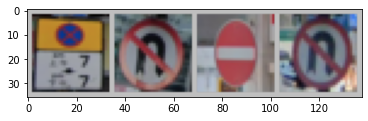

GroundTruth:  No7-7 NoUturn NoEntry NoUturn


In [226]:

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [227]:

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  No7-7 NoUturn NoEntry NoUturn


In [228]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 214 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 214 test images: 84 %


In [229]:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class End   is: 0.0 %
Accuracy for class NoUturn is: 77.3 %
Accuracy for class StopAllDay is: 62.2 %
Accuracy for class NoEntry is: 100.0 %
Accuracy for class NoLeft is: 0.0 %
Accuracy for class NoRight is: 100.0 %
Accuracy for class No7-7 is: 100.0 %
Accuracy for class NoStud is: 100.0 %


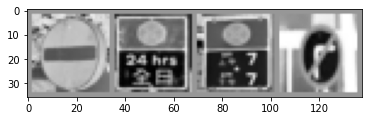

In [230]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [231]:
writer.add_graph(net, images)
writer.close()

In [232]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)